In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cftime
import pandas as pd
import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from importlib import reload
from functools import partial

Matplotlib created a temporary config/cache directory at /jobfs/123115068.gadi-pbs/matplotlib-dan3sg9r because the default path (/home/563/ab2313/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Matplotlib is building the font cache; this may take a moment.


In [3]:
import os, sys

sys.path.append(os.path.join(os.getcwd(), 'Documents', 'zecmip_stabilisation'))
import constants
sys.path.append(constants.MODULE_DIR)
import signal_to_noise_calculations as sn_calc
import my_stats

In [4]:
np.set_printoptions(precision=6, suppress=True, edgeitems=1)
xr.set_options(display_expand_data=False)

In [5]:
def find_stability_index(arr: np.ndarray, window: int, fraction: float = 0.5) -> int:
    """
    Determines the index at which stability is achieved in the input array.

    The algorithm works by sliding a window of a specified length over the array,
    checking each subset to determine if the fraction of unstable values (i.e., 
    values that are not finite) is below a certain threshold. If the fraction of 
    unstable values in a subset is below the threshold, the index where stability 
    is achieved is determined based on the last unstable value within the subset.

    If stability is achieved in the current subset, the function further checks if 
    the next element after the stable period is also stable by counting the number 
    of consecutive stable elements. The final index of stability is adjusted 
    accordingly.

    If stability is never achieved within the array, the function returns an 
    index calculated as the last checked index plus half the window length.

    Parameters:
    arr (np.ndarray): The input array containing numerical values.
    window (int): The length of the window used for stability checking.
    fraction (float): The threshold fraction of instability (default is 0.5).

    Returns:
    int: The index at which stability is first achieved.
    """
    finite_arr = np.isfinite(arr)

    lenght_of_selection = np.min([20, window])#window#int(window/2)

    for sel_start in range(len(finite_arr)-lenght_of_selection):
        # Make sub-selection
        finite_arr_selection = finite_arr[sel_start:sel_start+lenght_of_selection]
        # Number that are unstable (unstable =1, stable = 0)
        number_unstable = np.sum(finite_arr_selection)
        # Fraction that is unstalbe
        fraction_unstable = number_unstable/lenght_of_selection
        
        # If < 0.2 is unstalbe, then call stability immediately. Do not add consecs     
        if fraction_unstable < 0.33:
            return sel_start

        # If the fraction is less than fraciton - stability is achieved
        if fraction_unstable < fraction:
            # Figure out where the last unstable value occurs in selection
            last_arg = np.argwhere(finite_arr_selection==1)
            last_arg = last_arg[-1][-1] if len(last_arg) > 0 else 0
            last_arg = last_arg+1 # Always one behind, so add 1
            stable_year = sel_start + last_arg
            
            # The next element is one after the stable year - so why should it be stable there?
            if finite_arr[stable_year+1] == 1: 
                cosec_after_stabilisation = sn_calc.count_consecutive_ones(finite_arr[stable_year+1:])
                stable_year = stable_year + cosec_after_stabilisation+1

            stable_year = stable_year
            return stable_year

    # Stability never achieved return arg + the offset
    return sel_start + int(window/2)

# Setup - Demonstation

In [6]:
reload(sn_calc)

<module 'signal_to_noise_calculations' from '/home/563/ab2313/Documents/zecmip_stabilisation/src/signal_to_noise_calculations.py'>

In [7]:
simulation_length = 150
trend_length = 50
trend_step = 0.01 # 0.1
pi_length = 500

print(trend_length * trend_step)

linear_trend = np.arange(0, trend_length * trend_step, trend_step)
linear_trend = np.concatenate([linear_trend, [linear_trend[-1]] * (simulation_length-trend_length)])
random_noise = np.random.normal(0, 0.2, len(linear_trend))
time_series = linear_trend + random_noise

pi_control = np.random.normal(0, 0.2, pi_length)

0.5


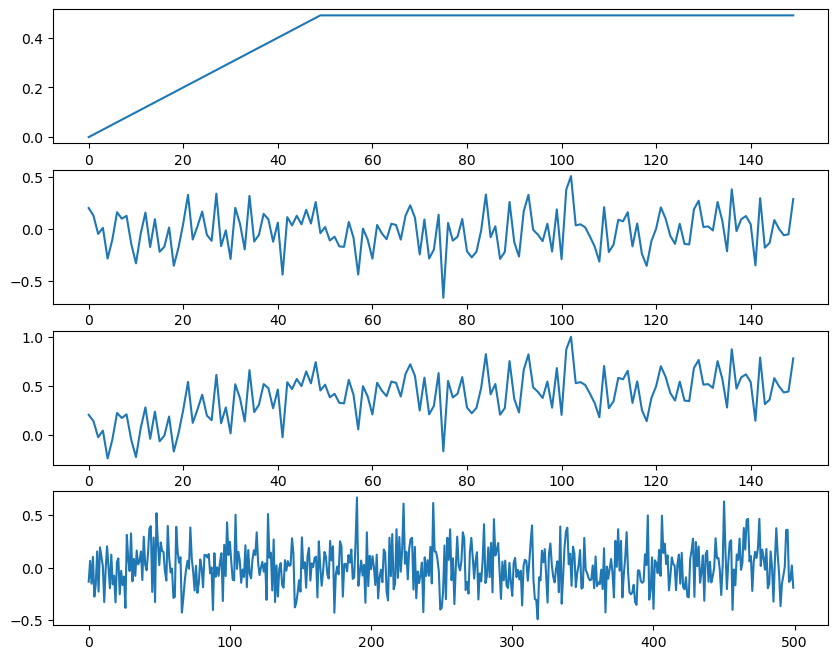

In [8]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8))
ax1.plot(linear_trend)
ax2.plot(random_noise)
ax3.plot(time_series)
ax4.plot(pi_control)


In [9]:
# Create a cftime range starting at year 0 for 100 years with yearly frequency
time = xr.cftime_range(start=cftime.datetime(1,1,1,0,0,0), periods=len(time_series), freq='YS')
pitime = xr.cftime_range(start=cftime.datetime(1,1,1,0,0,0), periods=len(pi_control), freq='YS')

# Create the DataArray
da = xr.DataArray(
    time_series,
    coords={
        "time": time
    },
    dims="time",
    name="tas"
)

pi_da = xr.DataArray(
    pi_control,
    coords={
        "time": pitime
    },
    dims="time",
    name="tas"
)

In [10]:
da

<xarray.DataArray 'tas' (time: 150)> Size: 1kB
0.201 0.1385 -0.02704 0.0406 -0.2439 ... 0.5757 0.4911 0.4299 0.4392 0.7771
Coordinates:
  * time     (time) object 1kB 0001-01-01 00:00:00 ... 0150-01-01 00:00:00

In [11]:
da_trend =  my_stats.trend_fit(da, method='polynomial', order=4)
da_detrend = da - da_trend

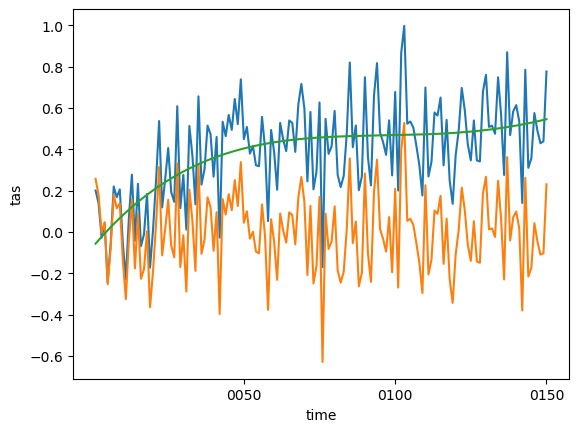

In [12]:
da.plot()
da_detrend.plot()
da_trend.plot()

In [13]:
windows = np.arange(**constants.ZECMIP_MULTI_WINDOW_PARAMS)
windows

array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40])

In [14]:
sn_da = sn_calc.signal_to_noise_ratio_multi_window(
    da, 
    windows,
    detrended_data=da_detrend,
    parallel=False,
    noise_type='static',
    logginglevel='ERROR'
)


In [15]:
sn_pi_da = sn_calc.signal_to_noise_ratio_multi_window(
    pi_da, 
    windows,
    parallel=False,
    noise_type='static',
    logginglevel='ERROR'
)

In [16]:
bounds_ds = sn_calc.upper_and_lower_bounds(sn_pi_da, 1, 99)

In [17]:
# The S/N ratio that is unstable - e.g. the A1 S/N where the pi-control is unstable
unstable_sn_da = sn_da.where(np.logical_or(
    sn_da>bounds_ds.upper_bound, # Greater than upper-bounds
    sn_da<bounds_ds.lower_bound)
                                     ) # Less than lower bound

In [18]:
unstable_sn_da.transpose(*['time', 'window']).values.shape

(140, 31)

In [19]:
year_stable_and_unstable_arr =\
    sn_calc.calcuate_year_stable_and_unstable(
    unstable_sn_da.transpose(*['time', 'window']).values,
    unstable_sn_da.window.values,
    max_val=110
    )

In [20]:
year_stable_and_unstable_arr

array([25., nan, nan, nan, nan, nan, nan])

In [21]:
year_stable = np.nanmax(np.take(year_stable_and_unstable_arr, [0,2,4,6]))
year_stable

25.0

In [22]:
# unstable_fraction_da = xr.apply_ufunc( #xr
#     sn_calc.get_percent_non_nan,
#     unstable_sn_da,
#     unstable_sn_da.window,
#     input_core_dims=[['time'], []],
#     output_core_dims=[['time']],
#     vectorize=True,
#     dask='parallelized',
#     output_dtypes=[np.float]
# ).compute()

In [23]:
# unstable_fraction_threshold_da = xr.where(unstable_fraction_da>0.4, 1, 0)

In [24]:
# total_stable_year_da = xr.apply_ufunc(
#     partial(sn_calc.find_stable_year_unsable_window_sel, windows=unstable_sn_da.window.values),
#     unstable_sn_da.squeeze(),
#     unstable_fraction_threshold_da.squeeze(),
#     input_core_dims=[['window', 'time'], ['time', 'window']], 
#     output_core_dims = [[]],
#     vectorize=True,
#     dask='parallelized',
#     output_dtypes=[np.float64]
# ).compute()

In [25]:
# total_stable_year_da.values.item()

In [26]:
# unstable_fraction_da.plot()

In [27]:
# unstable_fraction_threshold_da.plot()

In [28]:
# plt.plot(unstable_fraction_threshold_da.sum(dim='window').values)

In [29]:
# # Get the year that stabilisation occurs
# # Note: NOt sure why, but if this isn't done in two parts, this returns a tranpose error.
# year_stable_kwargs = dict(
#     input_core_dims=[['time'], []],
#     output_core_dims=[[]],
#     vectorize=True,
#     dask='parallelized',
#     output_dtypes=[np.float]
# )

# year_stable_all_window_da =xr.apply_ufunc(
#     find_stability_index,
#     unstable_sn_da,
#     unstable_sn_da.window,
#     **year_stable_kwargs
# ).compute()


In [30]:
unstable_sn_da['time'] = unstable_sn_da.time.dt.year.values

In [31]:
trend_length

50

In [32]:
# year_stable_da = year_stable_all_window_da.max(dim='window')
# year_stable_da

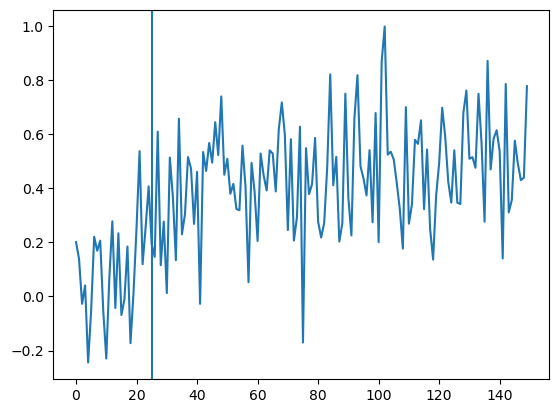

In [33]:
fig, ax = plt.subplots(1, 1)
ax.axvline(year_stable)

ax.plot(time_series)

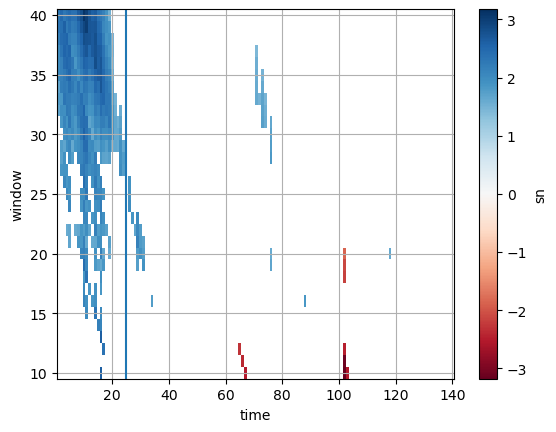

In [34]:
fig, ax = plt.subplots(1, 1)
unstable_sn_da.plot(ax=ax, cmap='RdBu')
# year_stable_all_window_da.plot(y='window')
# ax.axvline(total_stable_year_da.values.item())
ax.axvline(year_stable)

ax.grid()

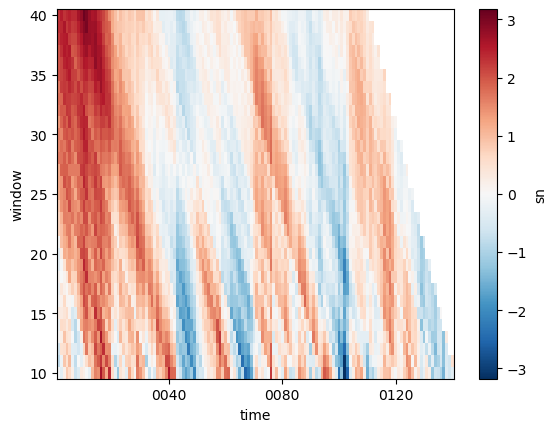

In [35]:
sn_da.plot()

# Distributions

In [36]:
import dask

In [37]:
# client.close()

In [38]:
from dask.distributed import Client
client = Client(memory_limit=None, threads_per_worker=1, n_workers=50)
client

- State start
-   Scheduler at:     tcp://127.0.0.1:44497
-   dashboard at:         /proxy/8787/status
- Registering Worker plugin shuffle
-         Start Nanny at: 'tcp://127.0.0.1:39801'
-         Start Nanny at: 'tcp://127.0.0.1:46793'
-         Start Nanny at: 'tcp://127.0.0.1:33341'
-         Start Nanny at: 'tcp://127.0.0.1:38675'
-         Start Nanny at: 'tcp://127.0.0.1:39823'
-         Start Nanny at: 'tcp://127.0.0.1:39461'
-         Start Nanny at: 'tcp://127.0.0.1:40233'
-         Start Nanny at: 'tcp://127.0.0.1:46421'
-         Start Nanny at: 'tcp://127.0.0.1:36231'
-         Start Nanny at: 'tcp://127.0.0.1:37283'
-         Start Nanny at: 'tcp://127.0.0.1:42881'
-         Start Nanny at: 'tcp://127.0.0.1:35909'
-         Start Nanny at: 'tcp://127.0.0.1:33303'
-         Start Nanny at: 'tcp://127.0.0.1:36239'
-         Start Nanny at: 'tcp://127.0.0.1:41297'
-         Start Nanny at: 'tcp://127.0.0.1:45661'
-         Start Nanny at: 'tcp://127.0.0.1:41429'
-         S

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 50
Total threads: 50,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44497,Workers: 50
Dashboard: /proxy/8787/status,Total threads: 50
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:37773,Total threads: 1
Dashboard: /proxy/37423/status,Memory: 0 B
Nanny: tcp://127.0.0.1:39801,


In [61]:
# client.cluster.scale(30)

-         Start Nanny at: 'tcp://127.0.0.1:35497'
-         Start Nanny at: 'tcp://127.0.0.1:40449'
-         Start Nanny at: 'tcp://127.0.0.1:38923'
-         Start Nanny at: 'tcp://127.0.0.1:41499'
-         Start Nanny at: 'tcp://127.0.0.1:37385'
-         Start Nanny at: 'tcp://127.0.0.1:33045'
-         Start Nanny at: 'tcp://127.0.0.1:36345'
-         Start Nanny at: 'tcp://127.0.0.1:39373'
-         Start Nanny at: 'tcp://127.0.0.1:42495'
-         Start Nanny at: 'tcp://127.0.0.1:40639'
-         Start Nanny at: 'tcp://127.0.0.1:33895'
-         Start Nanny at: 'tcp://127.0.0.1:44893'
-         Start Nanny at: 'tcp://127.0.0.1:38621'
-         Start Nanny at: 'tcp://127.0.0.1:45547'
-         Start Nanny at: 'tcp://127.0.0.1:44095'
-         Start Nanny at: 'tcp://127.0.0.1:42401'
-         Start Nanny at: 'tcp://127.0.0.1:34083'
-         Start Nanny at: 'tcp://127.0.0.1:38395'


In [ ]:
# def find_stable_year_unsable_window_sel(unstable_pattern_arr, unstable_fraction_arr, windows):
#     """
#     This function finds the first year in which all windows become stable. It checks when a pattern
#     becomes stable across different windows and returns the total year when stability is achieved.

#     Parameters:
#     ----------
#     unstable_pattern_arr : numpy.ndarray
#         2D array representing unstable patterns across different windows and years.
#     unstable_fraction_arr : numpy.ndarray
#         2D array representing the fraction of instability across different windows and years.
#         The shape should be the transpose of `unstable_pattern_arr`.

#     Returns:
#     -------
#     int
#         The first year in which all windows become stable.

#     Raises:
#     ------
#     AssertionError:
#         If the shape of `unstable_pattern_arr` does not match the reversed shape of `unstable_fraction_arr`.
#     """
    
#     # Ensure that the shapes of the arrays are compatible
#     assert unstable_pattern_arr.shape == unstable_fraction_arr.shape[::-1]
    
#     # Sum instability across years for each window
#     stable_num_arr = np.sum(unstable_fraction_arr, axis=1)

#     # Find the first year where all windows are stable (no instability)
#     first_year_all_stable = np.where(stable_num_arr == 0)[0][0]

#     # If the first year is stable from the start, return this year
#     if first_year_all_stable == 0:
#         return first_year_all_stable

#     # The year before the first fully stable year
#     stable_point_query_year = first_year_all_stable - 1

#     # Find windows that are unstable in the year before full stability
#     windows_that_are_unstable = unstable_fraction_arr[stable_point_query_year, :]

#     # Get indices of the unstable windows
#     window_unstable_args = np.where(windows_that_are_unstable == 1)[0]

#     larst_arg_list = []

#     for sarg in window_unstable_args:
#         # Select the window size for analysis
#         window = windows[sarg]

#         # Set the length of the selection window, max of 20 or the window size
#         lenght_of_selection = np.min([20, window])

#         # Select the analysis window: data from the unstable window at the query year onwards
#         # Ensure the dimension order is window first
#         anlsysis_window = unstable_pattern_arr[sarg, stable_point_query_year:stable_point_query_year + lenght_of_selection]

#         # Find the last stable index (where the data is finite) in the analysis window
#         last_arg = sn_calc.get_last_arg_v2(np.isfinite(anlsysis_window))
#         larst_arg_list.append(last_arg)

#     larst_arg_list = np.array(larst_arg_list)

#     # Calculate the maximum extension of stability required across the unstable windows
#     stable_year_addition_arg = np.argmax(larst_arg_list)
#     stable_year_addition = larst_arg_list[stable_year_addition_arg]
#     max_window = windows[window_unstable_args][stable_year_addition_arg]

#     # Calculate the total year when stability is achieved
#     total_year_stable = first_year_all_stable + stable_year_addition+int(max_window/2)
    
#     return total_year_stable

In [ ]:
reload(sn_calc)

In [121]:
import utils
logger = utils.get_notebook_logger()

In [149]:
def calcuate_year_stable_and_unstable_plus_window(time_window_arr, windows, number_attempts: int = 7, max_val:int=50,
                                     logginglevel='ERROR'):
    """
    ####!!!! This version adds the window length to the year of stabilisation
    
    Calculate the years of stability and instability in a time series.
    
    Parameters:
    - time_window_arr (np.ndarray): A 2D array representing the time series data for different windows.
    - windows (np.ndarray): An array containing the size of each window.
    - number_attempts (int): The maximum number of iterations for searching stability/instability. Default is 5.
    
    Returns:
    - year_list (np.ndarray): A cumulative sum array representing the years at which stability or instability is identified.
      If the number of identified years is less than the number of attempts, the remaining positions in the array will be NaN.
    """
    # Convert the time series data to a binary array where 1 represents
    # finite values and 0 represents NaNs or infinite values.
    utils.change_logging_level(logginglevel)

    # This is not used functinoally, but used defensivly
    window_shape = time_window_arr.shape[-1]

    # Number of attempts is needed later
    number_attemps_2 = number_attempts
    
    time_window_arr = np.where(np.isfinite(time_window_arr), 1, 0)
    
    bump_start=0
    next_year_list = []

    # Calculate the fraction of unstable points within each window.
    # time x window
    frac_unstable_arr = sn_calc.frac_non_zero_window(time_window_arr, windows)

    # First 10 years
    initial_fracs = frac_unstable_arr[:10, :]

    if np.any(initial_fracs >= 0.5):
        # If any of the fraction are greater than 0.5, then we are unstable 
        # and need to start looking for stability
        TEST_FOR_STABILITY = True
        TEST_FOR_INSTABILITY = False
    else:
        # Otherwise, we have started off with being stable
        # so start testing for instability
        TEST_FOR_STABILITY = False
        TEST_FOR_INSTABILITY = True
        # Append stable year 0 to array
        next_year_list.append(0)
        # We have already used one attempt
        number_attempts = number_attempts - 1
        


    i = 0
    while number_attempts >= 0:
        if i != 0:
            # Check if the end of the time series has been reached.
            if next_year_list[-1] >= time_window_arr.shape[0]: break
    
            # Cut the time series starting from the last identified year to the end.
            # The instability last at least as long as the window the fraction is taken
            # over
            #There are issues that can occur if the number of points
            # are all in a row, the stable year and the unstalbe year,
            # then both become the same. Thus, putting the negative one 
            # here fixes this
            time_window_arr = time_window_arr[next_year_list[-1]-1:, :]
    
            # Break if the remaining time series is too short for further analysis.
            if time_window_arr.shape[0] < 10: break
        if len(next_year_list)>=2: # At lesat two entries
            # There has only been least three years since the last change
            if next_year_list[-1] <= 3: # Only three years since last condition
                # Erase last two values - the are basically ontop
                # e.g. the first condition didn't really occur
                bump_start = np.nansum(next_year_list[:-2])#next_year_list[-1]
                next_year_list = next_year_list[:-2]
            else: bump_start=0
    
        # Calculate the fraction of unstable points within each window.
        frac_unstable_arr = sn_calc.frac_non_zero_window(time_window_arr, windows)
    
        if TEST_FOR_INSTABILITY:  # Searching for instability
            logger.info('Instability Search')
    
            # Set a threshold where instability is defined as the fraction of unstable points > 0.4.
            instability_condition = frac_unstable_arr >= 0.5
            logger.debug(f' - Instability_condition shape: {instability_condition.shape}')
    
            # Create a binary array where 1 indicates instability.
            frac_unstable_threshold_arr = np.where(instability_condition, 1, 0)
    
            # If no instability is detected, break the loop.
            if np.all(frac_unstable_threshold_arr == 0): break
    
            # Count the number of unstable points across all windows.
            number_unstable_across_window = np.nansum(frac_unstable_threshold_arr, axis=1)
            logger.debug(f' - number_unstable_across_window\n{number_unstable_across_window}')
    
            # Find the first year where instability is detected.
            first_year_condition_met = np.where(number_unstable_across_window > 0)[0][0]
            logger.debug(f' - {first_year_condition_met=}')
    
            window_args = np.where(frac_unstable_threshold_arr[first_year_condition_met, :]==1)[0]
            logger.debug(f' - {window_args=}')
    
            first_arg_list = []
            for sarg in window_args:
                length_of_selection = 10#np.min([10, int(window)])
                # Select the window size for analysis
                window = windows[sarg]
                anlsysis_window =\
                    time_window_arr[first_year_condition_met:first_year_condition_met + length_of_selection, sarg]
            
                first_unstable_point = np.where(anlsysis_window==1)[0][0]
                first_arg_list.append(first_unstable_point)
            logger.debug(f' - first_arg_list\n{first_arg_list}')
            first_arg_list = np.array(first_arg_list)
            year_addition = np.min(first_arg_list)
            logger.info(f' - {year_addition=}')
    
            year_val = first_year_condition_met+year_addition+1
            logger.info(f' - {year_val=}')
            # If the condition analysed is more than 45, break
            if np.cumsum(next_year_list)[-1] > max_val-5: break

            # Instability found, start looking for instability
            TEST_FOR_STABILITY = True
            TEST_FOR_INSTABILITY = False
            # number_attempts = number_attempts - 1
            # i += 1
    
      
        elif TEST_FOR_STABILITY:  # Searching for stability
            logger.info('Stability Search')

            # Set a threshold where stability is defined as the fraction of unstable points <= 0.2.
            # Shape time x window  
            frac_below_threshold = np.where(frac_unstable_arr < 0.5, 1, 0)
    
            # Count the number of unstable points across all windows.
            # Shape time
            number_windows_stable = np.nansum(frac_below_threshold, axis=1)
            logger.debug(f'number_windows_stable:\n{number_windows_stable}')
    
            # If every window is stable
            # Shape: time
            stability_condition = number_windows_stable == len(windows)

            logger.debug(f'stability condition array\n{stability_condition}')
            # print(stability_condition)
            # If stability is not found, break the loop.
            if np.all(stability_condition == False): break
    
            # Find the first year where stability is detected.
            first_year_condition_met = np.where(stability_condition)[0][0]
    
            #Identify the year before the first fully stable year.
            point_query_year = first_year_condition_met - 1
            logger.info(f' - {point_query_year=}')
            if point_query_year <0: point_query_year ==0
            # logger.info(f'{point_query_year}')
    
            # Extract values from the time series at the query year.
            # val_at_query_windows = time_window_arr[point_query_year, :]
            val_at_query_windows = frac_below_threshold[point_query_year, :]
            logger.debug(f'Values at window {val_at_query_windows}')
    
            # Find the windows that are stable at the query year.
            # This shoudl be == 0, as we are looking for when they 
            # are not stable (e.g unstable)
            window_args = np.where(val_at_query_windows == 0)[0]
            logger.debug(f' - window_args\n{window_args}')
            
    
            larst_arg_list = []
            # print(window_args)
            woi = []
            for sarg in window_args:
                # Get the window size for analysis.
                window = windows[sarg]
                woi.append(window)
    
                # Determine the length of the selection window, max of 10 or the window size.
                length_of_selection = 10#np.min([10, int(window)])
    
                # print(window)
                # Select the analysis window starting from the query year.
                analysis_window = time_window_arr[point_query_year:point_query_year + length_of_selection, sarg]
    
                # Find the last stable index in the analysis window.
                last_arg = sn_calc.get_last_arg_v2(analysis_window)
                larst_arg_list.append(last_arg)

            # Calculate the additional years needed for stability.
            larst_arg_list = np.array(larst_arg_list)
            year_addition_arg = np.argmax(larst_arg_list)
            year_addition = larst_arg_list[year_addition_arg]
            window_addition = woi[year_addition_arg]
            year_val = first_year_condition_met + year_addition + window_addition

            # Year of stabilisation found, start looking for other
            TEST_FOR_STABILITY = False
            TEST_FOR_INSTABILITY = True
        number_attempts = number_attempts - 1
        
        i += 1
  
    
        # Append the calculated year to the list.
        if bump_start:
            year_val=year_val + bump_start
            # remove the bump start after it has been used
            bump_start = 0

        # Append
        if year_val == 1: year_val = 0
        next_year_list.append(year_val)

        logger.info(f' - next_year_list\n{next_year_list}')
        # If the condition analysed is more than 45, break
        if np.cumsum(next_year_list)[-1] > max_val-5: break
        logger.info('Complete\n')


    # Calculate the cumulative sum of the years to get the year list.
    year_list = np.cumsum(next_year_list)


    # End point conditions
    # # If there are any values greater than 50, replace them with 50
    if np.any(year_list>max_val):
        year_list[np.where(year_list>max_val)] = max_val
        
    
    # # If not even (e.g. 1, 3) then finishing on instability
    # Need to assign unstable
    if not len(year_list)%2 and len(year_list)>1: 
        # Instability has been assigned at the last year
        # So chop of the last point
        if year_list[-1] == max_val:
            year_list = year_list[:-1]
        else:
            year_list = np.concatenate([year_list,[max_val]])

    # The model nevera actuyall stabilised, so assign 50
    if len(year_list) == 0:
        year_list = np.array([max_val])
        
    # Check how many 50s there are
    number_of_max_vals = len(np.where(year_list==max_val)[0])
    # IF there is more than one 50, remove
    if number_of_max_vals > 1:
        year_list = year_list[:-(number_of_max_vals-1)]

    
    # Ensure the year list has the same size as the number of attempts.
    # I is upwards counts of number of attempts
    if len(year_list) < number_attemps_2:
        year_list = np.concatenate([year_list, np.tile(np.nan, number_attemps_2 - len(year_list))])

    if len(year_list) != number_attemps_2:
        logger.info(f' - year_list length {len(year_list)} {number_attemps_2=}')
        logger.info(f' - year_list\n{year_list}')
        logger.info('\n')

    return year_list

In [150]:
def do_everything(trend_step, trend_length, variance=0.2):
    pi_length = 500
    simulation_length = 100
    linear_trend = np.arange(0, trend_length * trend_step, trend_step)
    linear_trend = np.concatenate([linear_trend, [linear_trend[-1]] * (simulation_length-trend_length)])
    random_noise = np.random.normal(0, variance, len(linear_trend))
    time_series = linear_trend + random_noise
    
    pi_control = np.random.normal(0, variance, pi_length)

    # Create a cftime range starting at year 0 for 100 years with yearly frequency
    time = xr.cftime_range(start=cftime.datetime(1,1,1,0,0,0), periods=len(time_series), freq='YS')
    pitime = xr.cftime_range(start=cftime.datetime(1,1,1,0,0,0), periods=len(pi_control), freq='YS')
    
    # Create the DataArray
    da = xr.DataArray(
        time_series,
        coords={
            "time": time
        },
        dims="time",
        name="tas"
    )
    
    pi_da = xr.DataArray(
        pi_control,
        coords={
            "time": pitime
        },
        dims="time",
        name="tas"
    )
    
    
    da_trend =  my_stats.trend_fit(da, method='polynomial', order=4)
    da_detrend = da - da_trend
    
    sn_da = sn_calc.signal_to_noise_ratio_multi_window(
        da, 
        windows,
        detrended_data=da_detrend,
        parallel=False,
        noise_type='static',
        logginglevel='ERROR'
    )
    sn_pi_da = sn_calc.signal_to_noise_ratio_multi_window(
        pi_da, 
        windows,
        parallel=False,
        noise_type='static',
        logginglevel='ERROR'
    )
    
    bounds_ds = sn_calc.upper_and_lower_bounds(sn_pi_da, 1, 99)
    
    # The S/N ratio that is unstable - e.g. the A1 S/N where the pi-control is unstable
    unstable_sn_da = sn_da.where(np.logical_or(
        sn_da>bounds_ds.upper_bound, # Greater than upper-bounds
        sn_da<bounds_ds.lower_bound)
                                         ) # Less than lower bound


    #### MEthod 3
    # calcuate_year_stable_and_unstable = partial(sn_calc.calcuate_year_stable_and_unstable, windows=unstable_sn_da.window.values)
    
    # year_stable_and_unstable_ds = xr.apply_ufunc(
    # calcuate_year_stable_and_unstable,
    # unstable_sn_da.transpose(*['time', 'window']),
    # input_core_dims=[['time', 'window']],
    # output_core_dims=[['stability_index']],
    # dask_gufunc_kwargs={'output_sizes': {'stability_index': 7}},
    # vectorize=True
    # )
        # total_stable_year_da = year_stable_and_unstable_ds.sel(stability_index=[1,3,5, 7]).max(dim='stability_index')

    year_stable_and_unstable_arr =\
        calcuate_year_stable_and_unstable_plus_window(
        # sn_calc.calcuate_year_stable_and_unstable(
        unstable_sn_da.transpose(*['time', 'window']).values,
        unstable_sn_da.window.values,
        max_val=110,
        number_attempts=7
        )
    return year_stable_and_unstable_arr
    # print(year_stable_and_unstable_arr)
    # print(stable_indices)
    # year_stable = year_stable_and_unstable_arr[0]#np.nanmax(year_stable_and_unstable_arr[::2])
    
    # return year_stable
    # 
    ######### Method 2
    # unstable_fraction_da = xr.apply_ufunc( #xr
    #     sn_calc.get_percent_non_nan,
    #     unstable_sn_da,
    #     unstable_sn_da.window,
    #     input_core_dims=[['time'], []],
    #     output_core_dims=[['time']],
    #     vectorize=True,
    #     dask='parallelized',
    #     output_dtypes=[np.float]
    # ).compute()
    
    # unstable_fraction_threshold_da = xr.where(unstable_fraction_da>0.4, 1, 0)

    # # print(unstable_sn_da)
    # # print(unstable_fraction_threshold_data)
    # total_stable_year_da = xr.apply_ufunc(
    #     partial(find_stable_year_unsable_window_sel, windows=unstable_sn_da.window.values),
    #     unstable_sn_da.squeeze(),
    #     unstable_fraction_threshold_da.squeeze(),
    #     input_core_dims=[['window', 'time'], ['time', 'window']], 
    #     output_core_dims = [[]],
    #     vectorize=True,
    #     dask='parallelized',
    #     output_dtypes=[np.float64]
    # ).compute()
    
    # return total_stable_year_da.values.item()


    ############## Method 1
   # year_stable_kwargs = dict(
   #      input_core_dims=[['time'], []],
   #      output_core_dims=[[]],
   #      vectorize=True,
   #      dask='parallelized',
   #      output_dtypes=[np.float]
   #  )
   #  # year_stable_all_window_da =xr.apply_ufunc(
    #     find_stability_index,
    #     unstable_sn_da,
    #     unstable_sn_da.window,
    #     **year_stable_kwargs
    # ).compute()
    
    
    # year_stable_da = year_stable_all_window_da.max(dim='window')
    # return year_stable_da.values.item()

In [151]:
def run_do_all_heaps(number_runs, variance):
    trend_step_dict = {}
    # np.arange(0.01, 0.11, 0.01)
    for trend_step in np.arange(0.001, 0.001*11, 0.001):
        print(f'\n{trend_step=}\n--------------\n')
        trend_dict = {}
        for trend_length in range(10, 55, 5):
            print(f'{trend_length=}, total_change = {trend_step*trend_length}\n')
            year_list = []
            for i in range(number_runs):
                # print(f'{i}, ', end='')
                year_vals = dask.delayed(do_everything)(trend_step, trend_length, variance=variance)
                # year = dask.delayed(do_everything)(trend_step, trend_length, variance=variance)
                # year = do_everything(trend_step, trend_length, variance=variance)
                # year_list.append(year)
                
            year_list = dask.compute(year_list)[0]
            trend_dict[trend_length] = year_list
        trend_step_dict[trend_step] = trend_dict
        # trend_df = pd.DataFrame(trend_dict)
    
    # Flatten the dictionary into a list of tuples
    data = [
        (trend_step, trend_length, year_list)
        for trend_step, trend_dict in trend_step_dict.items()
        for trend_length, year_list in trend_dict.items()
    ]
    
    # Create the DataFrame and set the MultiIndex
    df = pd.DataFrame(data, columns=['trend_step', 'trend_length', 'year_list']).set_index(['trend_step', 'trend_length'])
    
    # Explode the year_list column to create a row for each year
    exploded_df = df.explode('year_list')#.reset_index()

    mean_df = exploded_df.groupby(['trend_step', 'trend_length']).mean() #mean
    mean_df = mean_df.reset_index().pivot_table(
        index='trend_length', columns='trend_step', values='year_list').astype(float)
    mean_df.columns = mean_df.columns.round(4)

    return mean_df

In [181]:
def run_do_all_heaps_ds(number_runs, variance):
    trend_steps = np.arange(0.001, 0.001*11, 0.001)
    trend_lengths = np.arange(10, 55, 5)
    year_vals_list = []
    
    for trend_step in trend_steps:
        print(f'\n{trend_step=}\n--------------\n')
        for trend_length in trend_lengths:
            print(f'{trend_length=}, total_change = {trend_step*trend_length}\n')
            year_list = []
            for i in range(number_runs):
                # You can uncomment the following line if you want to track each iteration:
                # print(f'{i}, ', end='')
                year_vals = dask.delayed(do_everything)(trend_step, trend_length, variance=variance)
                year_list.append(year_vals)
                
            computed_year_list = dask.compute(*year_list)
            year_vals_list.append(computed_year_list)

    # Convert year_vals_list into a 4D array: (trend_step, trend_length, run, year_index)
    year_vals_array = np.array(year_vals_list).reshape(
        len(trend_steps), len(trend_lengths), number_runs, 7
    )
    
    # Create an xarray Dataset
    ds = xr.Dataset(
        {
            "year_vals": (["trend_step", "trend_length", "run", "year_index"], year_vals_array)
        },
        coords={
            "trend_step": trend_steps,
            "trend_length": trend_lengths,
            "run": np.arange(number_runs),
            "year_index": np.arange(7)
        }
    )
    
    # Calculate the mean over the 'run' dimension
    # mean_ds = ds.mean(dim='run')

    # Optionally, you can transpose or reshape this data for easier access or plotting
    # mean_df = mean_ds.to_dataframe().unstack('year_index')
    
    return ds


In [182]:
def calculate_error_df(mean_df):
    # Compute the error DataFrame
    error_df = mean_df.copy()
    for index in mean_df.index.values:
        error_df.loc[index] = np.abs((mean_df.loc[index] - index))*100/index
    error_df = error_df.round(0)
    return error_df

In [183]:
def binary_stable_unstable_assignment(year_list, expected_length=50):
    '''
    Assigning 1 for unstable and 0 for stable.

    The first value in 'year_list' is the year at which stability occurs.
    The second value is the year at which instability occurs.
    '''
    
    # Remove any NaN values from year_list and get the maximum year
    year_list = np.array(year_list)
    valid_years = year_list[~np.isnan(year_list)]

    # Need to make sure this finishes at 50
    # E.g if the climate stabilises at the year 13, then only 13 ones 
    # between the year 0 and 13 are applied
    if not np.any(year_list>=expected_length):
        year_list = np.concatenate([year_list, [expected_length]])

    end_point = int(np.nanmax(year_list))
    
    # Initialize the binary stability list, start with ones (unstable)
    binary_stability_list = np.ones(end_point)
    
    # Assign 0s for stable periods
    for i in range(0, len(valid_years), 2):
        start = int(valid_years[i])
        end = int(valid_years[i + 1]) if i + 1 < len(valid_years) else end_point
        binary_stability_list[start:end] = 0

    if len(binary_stability_list) < expected_length:
        binary_stability_list = np.concatenate([binary_stability_list, np.tile(np.nan, expected_length-len(binary_stability_list))])
    
    return binary_stability_list


In [216]:
ds_0p2 = run_do_all_heaps_ds(1000, 0.2)
mean_ds_0p2ds_0p2 = ds_0p2.mean(dim='run')
# mean_df_0p2 = mean_ds_0p2.sel(year_index=[0, 2]).max(dim='year_index').year_vals.to_dataframe().unstack('trend_step')
mean_df_0p2 = mean_ds_0p2.sel(year_index=[0]).max(dim='year_index').year_vals.to_dataframe().unstack('trend_step')

error_df_0p2 = calculate_error_df(mean_df_0p2)
mean_df_0p2.columns = mean_df_0p2.columns.get_level_values(1)


trend_step=0.001
--------------

trend_length=10, total_change = 0.01

trend_length=15, total_change = 0.015

trend_length=20, total_change = 0.02

trend_length=25, total_change = 0.025

trend_length=30, total_change = 0.03

trend_length=35, total_change = 0.035

trend_length=40, total_change = 0.04

trend_length=45, total_change = 0.045

trend_length=50, total_change = 0.05


trend_step=0.002
--------------

trend_length=10, total_change = 0.02

trend_length=15, total_change = 0.03

trend_length=20, total_change = 0.04

trend_length=25, total_change = 0.05

trend_length=30, total_change = 0.06

trend_length=35, total_change = 0.07

trend_length=40, total_change = 0.08

trend_length=45, total_change = 0.09

trend_length=50, total_change = 0.1


trend_step=0.003
--------------

trend_length=10, total_change = 0.03

trend_length=15, total_change = 0.045

trend_length=20, total_change = 0.06

trend_length=25, total_change = 0.075

trend_length=30, total_change = 0.09

trend_length=35, to

In [221]:
ds_0p2

<xarray.Dataset> Size: 5MB
Dimensions:       (trend_step: 10, trend_length: 9, run: 1000, year_index: 7)
Coordinates:
  * trend_step    (trend_step) float64 80B 0.001 0.002 0.003 ... 0.009 0.01
  * trend_length  (trend_length) int64 72B 10 15 20 25 30 35 40 45 50
  * run           (run) int64 8kB 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
  * year_index    (year_index) int64 56B 0 1 2 3 4 5 6
Data variables:
    year_vals     (trend_step, trend_length, run, year_index) float64 5MB 0.0...

In [222]:
binary_stability_stable_unstable_data = xr.apply_ufunc(
    binary_stable_unstable_assignment,
    ds_0p2,
    input_core_dims=[['year_index']],
    output_core_dims=[['time']],
    vectorize=True,
    dask_gufunc_kwargs = {'output_sizes':{'time':100}},
    kwargs = {'expected_length':110}
)

In [223]:
percent_runs_stable = binary_stability_stable_unstable_data.sum(dim='run')/len(binary_stability_stable_unstable_data.run.values)

In [225]:
percent_runs_stable.sel(trend_step=trend_step, trend_length=trend_length).values

<bound method Mapping.values of <xarray.Dataset> Size: 896B
Dimensions:       (time: 110)
Coordinates:
    trend_step    float64 8B 0.01
    trend_length  int64 8B 50
Dimensions without coordinates: time
Data variables:
    year_vals     (time) float64 880B 0.983 0.983 0.983 ... 0.081 0.081 0.081>

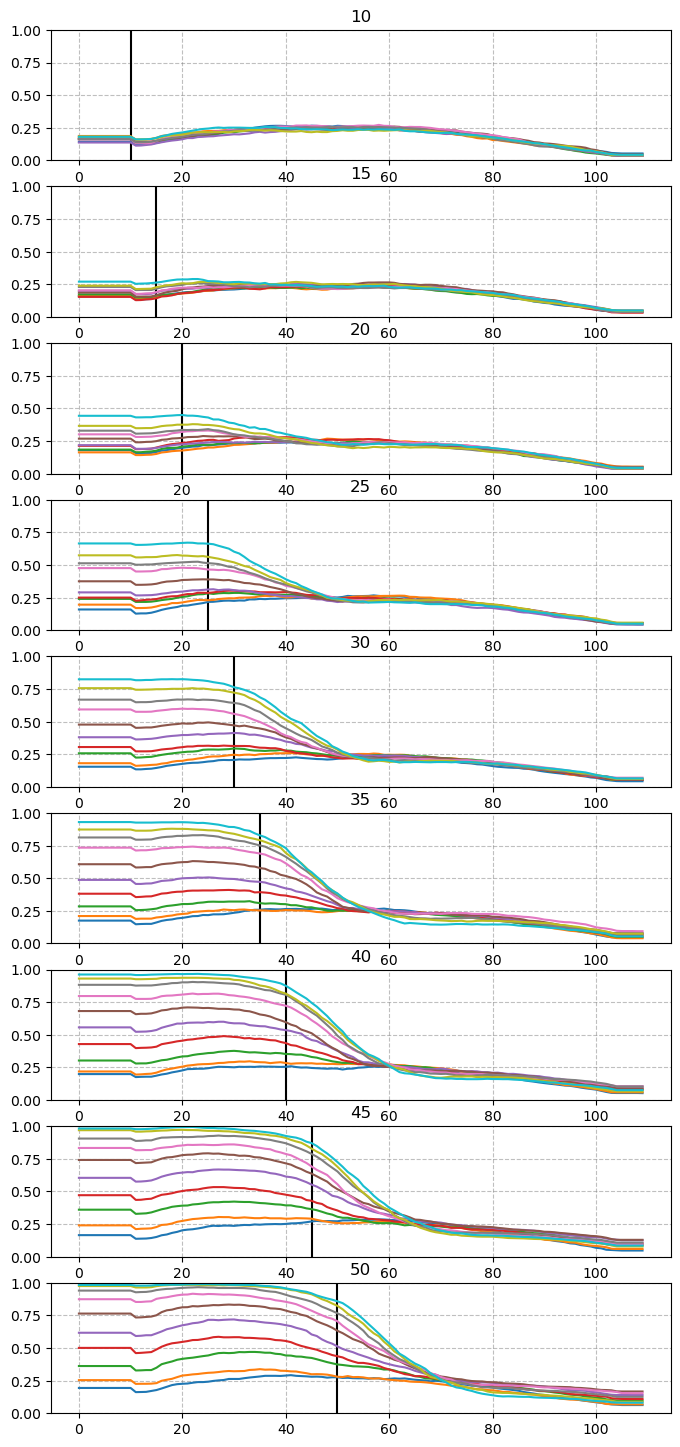

In [227]:
trend_step_vals = percent_runs_stable.trend_step.values
trend_length_vals = percent_runs_stable.trend_length.values

fig = plt.figure(figsize=(8, 20))
axes = [fig.add_subplot(len(trend_step_vals), 1, i+1) for i in range(len(trend_length_vals))]

for num, trend_length in enumerate(trend_length_vals):
    ax = axes[num]
    ax.set_title(trend_length)
    ax.axvline(trend_length, color='k')
    for trend_step in trend_step_vals:
        ax.plot(percent_runs_stable.sel(trend_step=trend_step, trend_length=trend_length).year_vals.values,
               label= trend_step)
        ax.set_ylim(0, 1)
        ax.grid(True, linestyle='--', alpha=0.5, color='grey')
    


In [75]:
# mean_df_0p2 = run_do_all_heaps(500, 0.2)
# error_df_0p2 = calculate_error_df(mean_df_0p2)

In [76]:
# mean_df_0p1 = run_do_all_heaps(200, 0.1)
# error_df_0p1 = calculate_error_df(mean_df_0p1)

In [77]:
# mean_df_0p4 = run_do_all_heaps(200, 0.4)
# error_df_0p4 = calculate_error_df(mean_df_0p4)

In [120]:
# std_df = exploded_df.groupby(['trend_step', 'trend_length']).std()
# std_df = std_df.reset_index().pivot_table(
#     index='trend_length', columns='trend_step', values='year_list').astype(float)
# std_df.columns = std_df.columns.round(4)

In [121]:
# # Compute the error DataFrame
# std_percent_df = std_df.copy()
# for index in std_df.index.values:
#     std_percent_df.loc[index] = std_df.loc[index]*100/index
# std_percent_df = std_percent_df.round(0)

In [157]:
# Compute the total change array
total_change = mean_df_0p2.index.values[:, np.newaxis] * mean_df_0p2.columns.values

# Create a new DataFrame for total change
total_change_df = pd.DataFrame(total_change, index=mean_df_0p2.index, columns=mean_df_0p2.columns)
total_change_df

trend_step,0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,0.010
trend_length,,,,,,,,,,
10,0.010,0.02,0.030,0.04,0.050,0.06,0.070,0.08,0.090,0.10
15,0.015,0.03,0.045,0.06,0.075,0.09,0.105,0.12,0.135,0.15
20,0.020,0.04,0.060,0.08,0.100,0.12,0.140,0.16,0.180,0.20
25,0.025,0.05,0.075,0.10,0.125,0.15,0.175,0.20,0.225,0.25
30,0.030,0.06,0.090,0.12,0.150,0.18,0.210,0.24,0.270,0.30
35,0.035,0.07,0.105,0.14,0.175,0.21,0.245,0.28,0.315,0.35
40,0.040,0.08,0.120,0.16,0.200,0.24,0.280,0.32,0.360,0.40
45,0.045,0.09,0.135,0.18,0.225,0.27,0.315,0.36,0.405,0.45
50,0.050,0.10,0.150,0.20,0.250,0.30,0.350,0.40,0.450,0.50


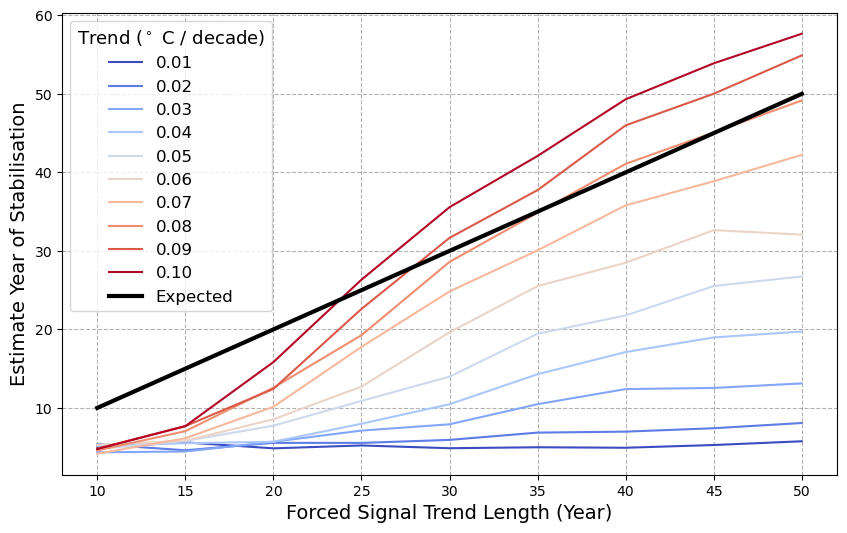

In [228]:
import matplotlib.lines as mlines

fig, ax = plt.subplots(figsize=(10, 6))
expected = np.arange(10, 51, 1)
# Define colormap
cmap = cm.get_cmap('coolwarm', len(mean_df_0p2.columns))

# Plot each line with different colors from the colormap
for i, column in enumerate(mean_df_0p2.columns):
    ax.plot(mean_df_0p2.index, mean_df_0p2[column], color=cmap(i / len(mean_df_0p2.columns)), label=f'{column*10:.2f}')

# for i, column in enumerate(mean_df_0p1.columns):
#     ax.plot(mean_df_0p1.index, mean_df_0p1[column], color=cmap(i / len(mean_df_0p1.columns)),# label=column,
#             linestyle='dotted')

# for i, column in enumerate(mean_df_0p4.columns):
#     ax.plot(mean_df_0p4.index, mean_df_0p4[column], color=cmap(i / len(mean_df_0p4.columns)), #label=column, 
#             linestyle='--')

# Add expected line
ax.plot(expected, expected, color='k', label='Expected', linewidth=3)
ax.legend(title='Trend ($^\circ$ C / decade)', title_fontsize='13', fontsize='12')

# Create custom legend handles for linestyles
# solid_line = mlines.Line2D([], [], color='black', linestyle='-', label='Variance = 0.2')
# dotted_line = mlines.Line2D([], [], color='black', linestyle=':', label='Variance = 0.1')
# dashed_line = mlines.Line2D([], [], color='black', linestyle='--', label='Variance = 0.4')

# Add the custom handles to the legend
# ax.legend(handles=[solid_line, dotted_line, dashed_line], title='Trend ($^\circ C) / year$', title_fontsize=13, fontsize=12)

# Customize labels and title
ax.set_xlabel('Forced Signal Trend Length (Year)', fontsize=14)
ax.set_ylabel('Estimate Year of Stabilisation', fontsize=14)

ax.grid(linestyle='--', color='grey', alpha=0.6)


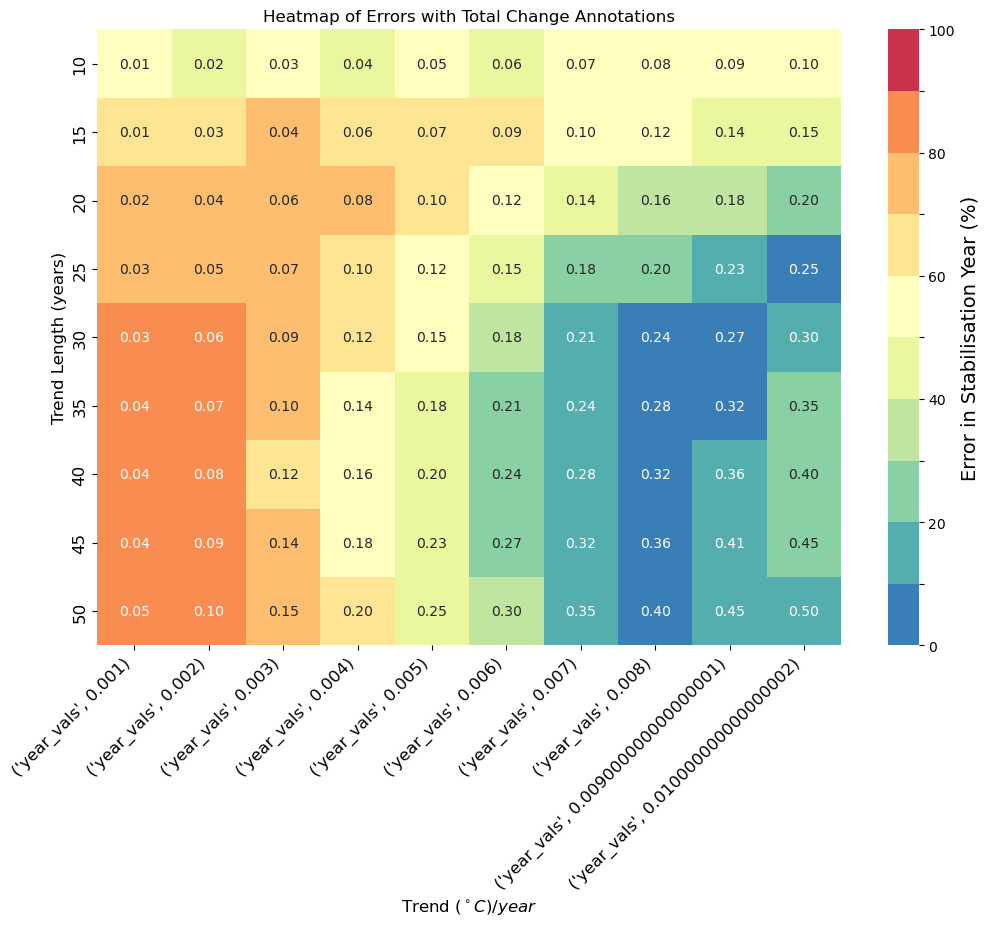

In [167]:

# Define your levels and colors
levels = np.arange(0, 110, 10)
colors = sns.color_palette('Spectral_r', n_colors=len(levels))  # Generate a color palette

# Create a discrete colormap
cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=len(levels))

# Plot heatmap of errors with annotations showing total change
fig, ax = plt.subplots(figsize=(12, 8))

# Plot heatmap with colors corresponding to the errors
heatmap = sns.heatmap(error_df_0p2, cmap=cmap, norm=norm, annot=total_change_df, fmt=".2f", ax=ax)
                      # cbar_kws={'label': })

# Customize color bar
cbar = heatmap.collections[0].colorbar
cbar.set_ticks(levels)  # Set ticks on the color bar
 # Replace every second label with ''
cbar.set_ticklabels([f'{level}' if idx % 2 == 0 else '' for idx, level in enumerate(levels)]) 
cbar.set_label('Error in Stabilisation Year (%)', fontsize=14)  # Set the title and adjust font size


ax.set_xticklabels(error_df_0p2.columns.round(4));

# Set plot titles and labels
ax.set_title('Heatmap of Errors with Total Change Annotations')
ax.set_xlabel(r'Trend ($^\circ C) / year$', fontsize=12)
ax.set_ylabel('Trend Length (years)', fontsize=12)

# Rotate and resize x-axis tick labels
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12);

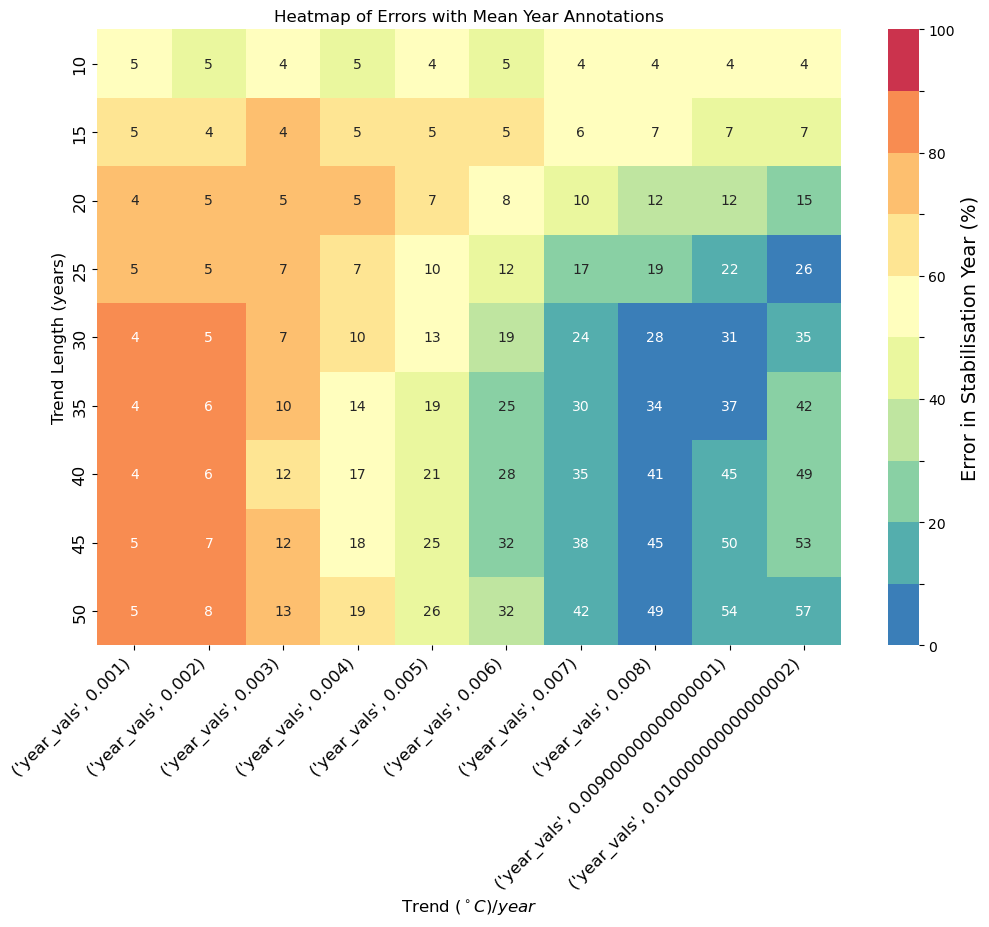

In [168]:

# Define your levels and colors
levels = np.arange(0, 110, 10)
colors = sns.color_palette('Spectral_r', n_colors=len(levels))  # Generate a color palette

# Create a discrete colormap
cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=len(levels))

# Plot heatmap of errors with annotations showing total change
fig, ax = plt.subplots(figsize=(12, 8))

# Plot heatmap with colors corresponding to the errors
heatmap = sns.heatmap(error_df_0p2, cmap=cmap, norm=norm, annot=mean_df_0p2.astype(float).astype(int),
                      fmt=".0f", ax=ax)
                      # cbar_kws={'label': })

# Customize color bar
cbar = heatmap.collections[0].colorbar
cbar.set_ticks(levels)  # Set ticks on the color bar
 # Replace every second label with ''
cbar.set_ticklabels([f'{level}' if idx % 2 == 0 else '' for idx, level in enumerate(levels)]) 
cbar.set_label('Error in Stabilisation Year (%)', fontsize=14)  # Set the title and adjust font size


ax.set_xticklabels(error_df_0p2.columns.round(4));

# Set plot titles and labels
ax.set_title('Heatmap of Errors with Mean Year Annotations')
ax.set_xlabel(r'Trend ($^\circ C) / year$', fontsize=12)
ax.set_ylabel('Trend Length (years)', fontsize=12)

# Rotate and resize x-axis tick labels
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12);

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
expected = np.arange(10, 51, 1)
# Define colormap
cmap = cm.get_cmap('coolwarm', len(mean_df.columns))

# Plot each line with different colors from the colormap
for i, column in enumerate(mean_df_0p2.columns):
    ax.plot(mean_df_0p2.index, mean_df_0p2[column], color=cmap(i / len(mean_df_0p2.columns)), label=column)

for i, column in enumerate(mean_df_0p1.columns):
    ax.plot(mean_df_0p1.index, mean_df_0p1[column], color=cmap(i / len(mean_df_0p1.columns)), label=column,
           linestyle='dotted')

for i, column in enumerate(mean_df_0p4.columns):
    ax.plot(mean_df_0p4.index, mean_df_0p4[column], color=cmap(i / len(mean_df_0p4.columns)), label=column, 
           line_style='--')

# Add expected line
ax.plot(expected, expected, color='k', label='Expected', linewidth=3)

# Customize labels and title
ax.set_xlabel('Forced Signal Trend Length (Years)', fontsize=14)
ax.set_ylabel('Estimate Year of Stabilisation', fontsize=14)

ax.legend(title='Trend ($^\circ C) / year$', title_fontsize='13', fontsize='12')
ax.grid(linestyle='--', color='grey', alpha=0.6)


In [ ]:
# Plot heatmap
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
sns.heatmap(std_df.astype(float), cmap='viridis', annot=True, fmt=".2f", cbar_kws={'label': 'Mean Value'})
ax.set_title('Heatmap of Standard Deviation by Trend Length and Trend Step')
ax.set_xlabel(r'Trend ($^\circ C) / year$', fontsize=12)
ax.set_ylabel('Trend Length (years)', fontsize=12)
ax.set_xticklabels(error_df.columns.round(2));
# Rotate and resize x-axis tick labels
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotate labels by 45 degrees and set font size
plt.yticks(fontsize=12) ;

In [ ]:

# Plot heatmap
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
heatmap = sns.heatmap(mean_df.astype(float), cmap='Spectral_r', annot=True, fmt=".0f",
                      cbar_kws={'label': 'Mean Value'})

# Access and adjust color bar title
cbar = heatmap.collections[0].colorbar
cbar.set_label('Mean Year of Stabilisation', fontsize=14)  # Set color bar title and adjust font size

# Set plot titles and labels
ax.set_title('Heatmap of Mean Values by Trend Length and Trend Step', fontsize=16)  # Adjust title font size
ax.set_xlabel(r'Trend ($^\circ C) / year$', fontsize=14)
ax.set_ylabel('Trend Length (years)', fontsize=14)
ax.set_xticklabels(mean_df.columns.round(4));

# Rotate and resize x-axis tick labels
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotate labels by 45 degrees and set font size
plt.yticks(fontsize=12)

plt.show()


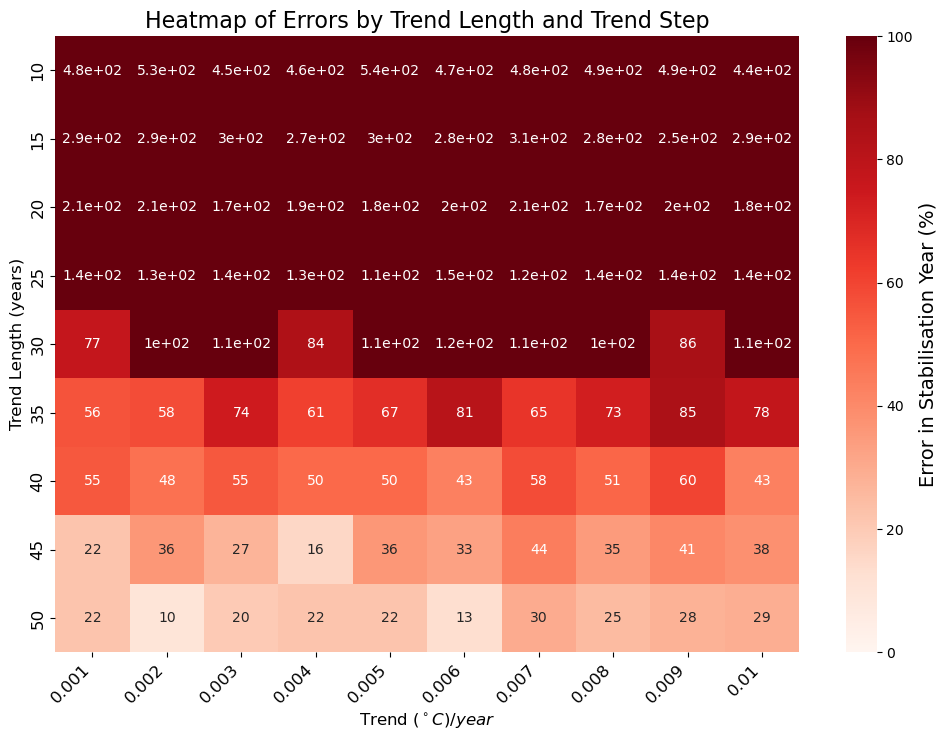

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot heatmap of errors
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
heatmap = sns.heatmap(error_df_0p2, cmap='Reds', annot=True, vmin=0, vmax=100, cbar_kws={'label': 'Error Value'})

# Access the color bar from the heatmap
cbar = heatmap.collections[0].colorbar
cbar.set_label('Error in Stabilisation Year (%)', fontsize=14)  # Set the title and adjust font size

# Set plot titles and labels
ax.set_title('Heatmap of Errors by Trend Length and Trend Step', fontsize=16)  # Adjust title font size
ax.set_xlabel(r'Trend ($^\circ C) / year$', fontsize=12)
ax.set_ylabel('Trend Length (years)', fontsize=12)
ax.set_xticklabels(error_df_0p2.columns.round(4));

# Rotate and resize x-axis tick labels
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotate labels by 45 degrees and set font size
plt.yticks(fontsize=12)

plt.show()


NameError: name 'error_df' is not defined

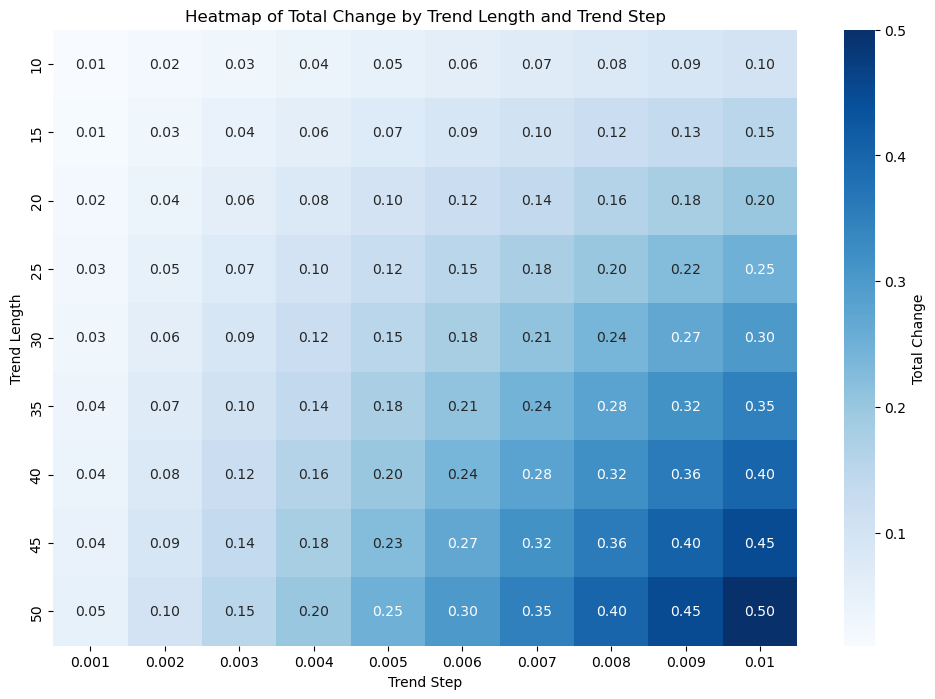

In [78]:

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
sns.heatmap(total_change_df, cmap='Blues', annot=True, fmt=".2f", cbar_kws={'label': 'Total Change'})
ax.set_title('Heatmap of Total Change by Trend Length and Trend Step')
ax.set_xlabel('Trend Step')
ax.set_ylabel('Trend Length')
ax.set_xticklabels(error_df.columns.round(2));

# Rotate and resize x-axis tick labels
plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotate labels by 45 degrees and set font size
plt.yticks(fontsize=10);

In [ ]:
# # Plot heatmap of errors
# fig = plt.figure(figsize=(12, 8))
# ax = fig.add_subplot(111)
# sns.heatmap(std_percent_df, cmap='Reds', annot=True, vmax=100, cbar_kws={'label': 'Error Value'})
# ax.set_title('Heatmap of Errors by Trend Length and Trend Step')
# ax.set_xlabel(r'Trend ($^\circ C) / year$', fontsize=12)
# ax.set_ylabel('Trend Length (years)', fontsize=12)
# # ax.set_xticks(rotation=45)  # Rotate x-axis labels for better readability
# ax.set_xticklabels(std_percent_df.columns.round(2));
# # Rotate and resize x-axis tick labels
# plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotate labels by 45 degrees and set font size
# plt.yticks(fontsize=12) ;